<a href="https://colab.research.google.com/github/juh5ng/juh5ng.github.io/blob/master/The_Red_Dynamic_Pricing_Part5_(%EA%B3%B5%EC%9C%A0%EC%9E%90%EB%A3%8C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The Red: 비즈니스의 운명을 바꾸는 Dynamic Pricing
##Part5.  시뮬레이션 기반 실습 - 자동화된 가격 최적화 머신


마지막 파트는 상당히 복잡한 실습입니다. 

연속적인 시간 프레임 안에서 가격을 설정하고 제품을 판매하는 상황입니다. 

가격에 대해 시시각각 변화하는 수요를 통해 가격탄력성을 판단하고 최적의 가격을 계산하여 추구하여 나갑니다.

수요에는 예측할 수 없는 요인이 포함되어 있기에 (노이즈) 이를 추정하고, 자동으로 최적의 가격을 찾는 알고리즘을 구현합니다. 

단일 상품을 다루는 비즈니스에서 사용하기에는 다소 구현이 복잡해지면서도, 그에 반해 지나치게 문제를 단순화하는 측면이 있어, 사용하기가 어려울 수도 있습니다.

하지만 수많은 상품을 다루는 이커머스와 같은 비즈니스에서는 이러한 방법을 사용하기 좋습니다. 

In [ ]:
import numpy as np
import pandas as pd

import itertools

import matplotlib
import matplotlib.pyplot as plt


In [ ]:
matplotlib.rcParams['figure.figsize'] = [10.0, 6.0]
matplotlib.rcParams['lines.marker'] = '.'

pd.options.display.float_format = '{:,.2f}'.format


In [ ]:
# From part3
np.random.seed(200)

unknown_theta0 = 50
unknown_theta1 = -0.5 

# part3 에서 사용했던 함수, part3 때와는 theta 값이 다름 
def sample_actual_demand(p): 
    demand = unknown_theta0 + unknown_theta1 * p
    demand = max(demand, 0) # 수요는 0보다 크다는 조건을 추가    
    return np.random.poisson(demand)

print(sample_actual_demand(50))
print(sample_actual_demand(50))
print(sample_actual_demand(50))

36
26
29


In [ ]:
# part3에서는 수십~수백 개의 다양한 가격-수요 샘플을 통해 가격민감도를 추정해 보았다. 
# 이는 사실 상당히 괜찮은 조건이다. 

# 이번 실습에서는, 충분한 관측값을 가지기 어려운 경우를 가정해 보자. 
# 극단적으로, 단 1개의 관측값으로 가격탄력성을 판단해야 한다면? 

# (아주 러프한 수준으로 판단해야 하지만, 정밀하게 판매나 이익을 최적화하는게 목표가 아닌 러프한 가격이동을 위한 것으로 생각한다)

part3에서는 수십~수백 개의 다양한 가격-수요 샘플을 통해 가격민감도를 추정해 보았다. 
이는 사실 상당히 괜찮은 조건이다. 

이번 실습에서는, 충분한 관측값을 가지기 어려운 경우를 가정해 보자. 
극단적으로, 단 1개의 관측값으로 가격탄력성을 판단해야 한다면? 


In [ ]:
theta0_space = [30, 40, 50, 60, 70]
theta1_space = [-1, -0.7, -0.5, -0.3] # 한정된 범위


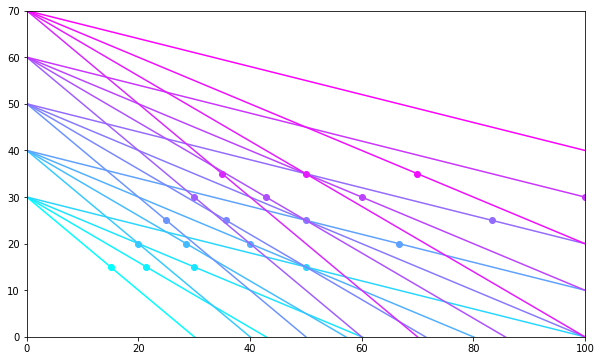

In [ ]:
# 설명용 그림을 그려보자
p = np.linspace(0, 100)

colors = plt.cm.cool(np.linspace(0,1,len(theta0_space) * len(theta1_space)))
i = 0
for theta0, theta1 in itertools.product(theta0_space, theta1_space):
  d = theta0 + theta1 * p
  plt.plot(p, d, color=colors[i], marker='')

  optimal_p_for_revenue = -1/2 * theta0 / theta1
  optimal_d = theta0 + theta1 * optimal_p_for_revenue

  plt.plot(optimal_p_for_revenue, optimal_d, color=colors[i], marker='o')

  i+=1 

ax = plt.gca() # Get Current Axes
ax.set_xlim([0, 100])
ax.set_ylim([0, 70])

plt.show()


In [ ]:

def find_next_rough_price_point(p, actual_demand):
  next_p_candidate = 0
  minimum_distance = float('inf')

  for theta0, theta1 in itertools.product(theta0_space, theta1_space):
    expected_demand = theta0 + theta1 * p
    expected_demand = max(expected_demand, 0)
    optimal_price = -1/2 * theta0 / theta1

    distance = abs(expected_demand - actual_demand)
    if(distance < minimum_distance):
      minimum_distance = distance
      next_p_candidate = optimal_price
  return next_p_candidate


initial_p = 20
actual_demand_0 = sample_actual_demand(initial_p)
print('actual_demand_0', actual_demand_0)

p_1 = find_next_rough_price_point(initial_p, actual_demand_0)
print('price change:', initial_p, '->', p_1)

actual_demand_1 = sample_actual_demand(p_1)
print('actual_demand_1', actual_demand_1)

p_2 = find_next_rough_price_point(p_1, actual_demand_1)
print('price change:', p_1, '->', p_2)


optimal_p_for_revenue = -1/2 * unknown_theta0 / unknown_theta1
print('(unknown) optimal price:', optimal_p_for_revenue)

# 러프한 결과로 시도할때마다 결과가 다르다
# 처음 결과보다는 낫다는데 의의를 둔다

actual_demand_0 37
price change: 20 -> 35.714285714285715
actual_demand_1 42
price change: 35.714285714285715 -> 60.0
(unknown) optimal price: 50.0


In [ ]:
# 위 연습을 시간단위로 계속 한다고 생각하자 

T = 300
t_interval = range(T) 

initial_p = 20

demand_points = np.array([])
price_points = np.array([])

p = initial_p
for t in t_interval:
    price_points = np.append(price_points, p)
               
    actual_demand = sample_actual_demand(p)
    demand_points = np.append(demand_points, actual_demand)
    p_next = find_next_rough_price_point(p, actual_demand)
    p = p_next 

df = pd.DataFrame({
  't':t_interval,
  'price': price_points,
  'demand': demand_points,
})
df['revenue'] = df['demand'] * df['price']


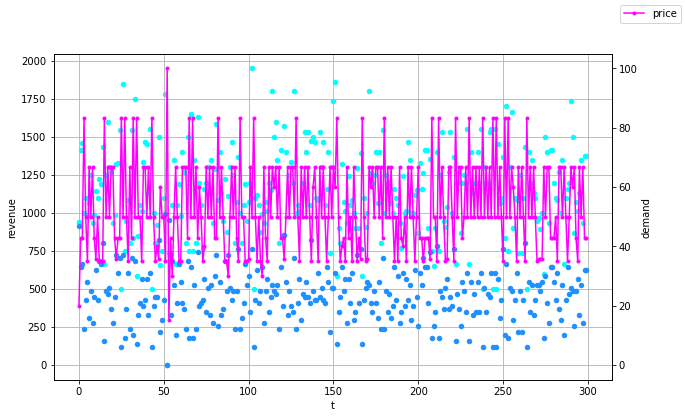

In [ ]:
ax = df.plot.scatter(x='t', y='revenue', legend=False, color='cyan', grid=True)
ax2 = ax.twinx()
df.plot(x='t', y='price', ax=ax2, legend=False, color='magenta')
df.plot.scatter(x='t', y='demand', ax=ax2, legend=False, color='dodgerblue')
ax.figure.legend()

In [ ]:
df.groupby('price').mean()

,t,demand,revenue
price,,,
15.00,53.00,49.00,735.00
20.00,0.00,47.00,940.00
30.00,83.67,35.00,"1,050.00"
35.00,141.05,32.07,"1,122.44"
35.71,156.33,33.25,"1,187.50"
40.00,116.50,29.00,"1,160.00"
42.86,143.09,29.12,"1,248.05"
50.00,154.76,24.63,"1,231.32"
60.00,155.25,21.62,"1,297.50"


In [ ]:
df.mean()
# optimal price 와는 거리가 약간 있지만, 평균 가격을 보면 10% 내외로 근접함

t           149.50
price        53.54
demand       23.48
revenue   1,147.21
dtype: float64

In [ ]:
df['cluster'] = (df['t']/100).astype('int64')
df.groupby('cluster').mean()

,t,price,demand,revenue
cluster,,,,
0,49.50,52.69,23.92,"1,115.56"
1,149.50,52.96,23.74,"1,180.45"
2,249.50,54.98,22.77,"1,145.60"


In [ ]:
# exponential하게 기간을 늘려가며 초기에는 빠른 탐색, 후기에는 안정적인 가격을 운영하는 방법
# (복잡도에 비해 핵심내용은 아니므로 이부분은 가볍게 살펴봅시다) 

def exp_intervals(T):          
    result = np.array([])
    for i in range(0, T):
      chunk = np.array([i]).repeat(1.5 ** i)
      result_candidate = np.append(result, chunk)
      print(len(result), len(chunk), len(result_candidate))
      if len(result_candidate) > T:
        return np.append(result, np.full(T - len(result), i-1))
      else:
        result = result_candidate
        
T = 1000
t_exp_interval = exp_intervals(T+1)
print(t_exp_interval)

0 1 1
1 1 2
2 2 4
4 3 7
7 5 12
12 7 19
19 11 30
30 17 47
47 25 72
72 38 110
110 57 167
167 86 253
253 129 382
382 194 576
576 291 867
867 437 1304
[ 0.  1.  2. ... 14. 14. 14.]


In [ ]:
t_interval = range(T)                 

initial_p = 10

t_interval_start = 0 # interval start point

price_points = np.array([])
demand_points = np.array([])

p = initial_p
for t in t_interval:              
    price_points = np.append(price_points, p)
    actual_demand = sample_actual_demand(p)
    demand_points = np.append(demand_points, actual_demand)

    if(t_exp_interval[t] != t_exp_interval[t+1]):
      interval_mean_demand = np.mean(demand_points[t_interval_start : t + 1])
      p_next = find_next_rough_price_point(p, interval_mean_demand)
      p = p_next 
      t_interval_start = t+1
    
df = pd.DataFrame({
  't': t_interval,
  'price': price_points,
  'demand': demand_points,
})
df['revenue'] = df['demand'] * df['price']


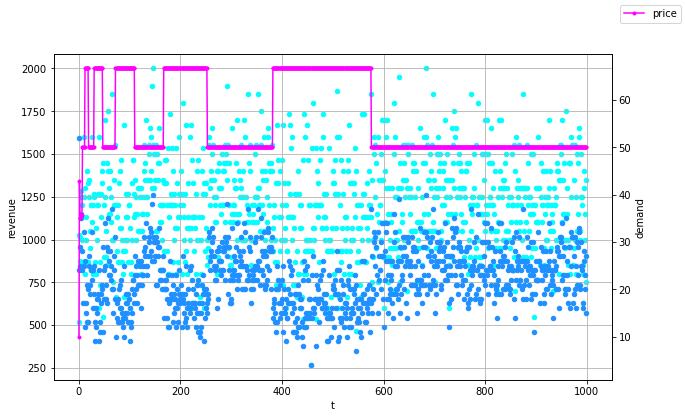

In [ ]:
ax = df.plot.scatter(x='t', y='revenue', legend=False, color='cyan', grid=True)
ax2 = ax.twinx()
df.plot(x='t', y='price', ax=ax2, legend=False, color='magenta')
df.plot.scatter(x='t', y='demand', ax=ax2, legend=False, color='dodgerblue')
ax.figure.legend()

# 빠른 시간내에 알맞은 가격을 찾아감
# 하지만 러프한 방식이기에 최적의 가격을 찾는데데 불안정한 모습을 보임 
# (눈으로만 봐도 66보다는 50이 낫다는걸 알 수 있음 - 앞전같이 매번 가겪 바꿀때는 알기 어려움)
# 좀 더 잘 하려면, 이와 같은 단편적인 방법이 아닌 지속적인 실험을 통해 최적의 가격을 찾을 수 있음

In [ ]:
df['cluster'] = (df['t']/100).astype('int64')
df.groupby('cluster').mean()

,t,price,demand,revenue
cluster,,,,
0,49.50,57.47,20.58,"1,123.58"
1,149.50,57.17,22.59,"1,256.83"
2,249.50,58.83,21.12,"1,207.33"
3,349.50,53.00,24.23,"1,263.17"
4,449.50,66.67,16.70,"1,113.33"
5,549.50,62.67,19.03,"1,167.67"
6,649.50,50.00,24.54,"1,227.00"
7,749.50,50.00,24.97,"1,248.50"
8,849.50,50.00,24.28,"1,214.00"


In [ ]:
df.groupby('price').mean()

,t,demand,revenue,cluster
price,,,,
10.00,0.00,52.00,520.00,0.00
35.00,2.50,27.00,945.00,0.00
35.71,5.00,33.00,"1,178.57",0.00
42.86,1.00,24.00,"1,028.57",0.00
50.00,590.54,24.92,"1,246.08",5.40
66.67,336.36,16.92,"1,127.68",2.87


### 톰슨샘플링

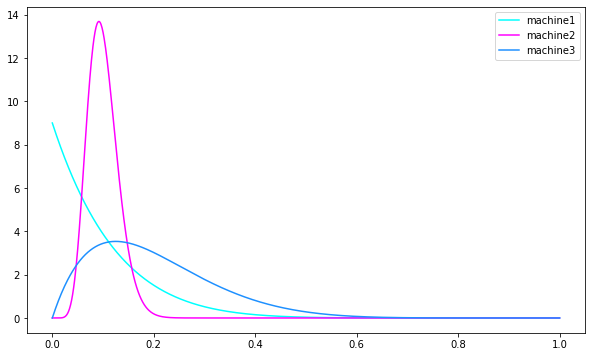

In [ ]:
# 베타분포를 알아보자  
# 슬롯머신을 여러번 당긴 결과를 해석할 때 어떤 머신이 가장 좋다고 봐야하나?

from scipy.stats import beta

x = np.linspace(0, 1, 1000)

m1 = beta.pdf(x, 1, 9)
m2 = beta.pdf(x, 10, 90)
m3 = beta.pdf(x, 2, 8)

fig, ax = plt.subplots(1, 1)
ax.plot(x, m1, label='machine1', color='cyan', marker='')
ax.plot(x, m2, label='machine2',color='magenta', marker='')
ax.plot(x, m3, label='machine3',color='dodgerblue', marker='')

ax.legend()
plt.show()

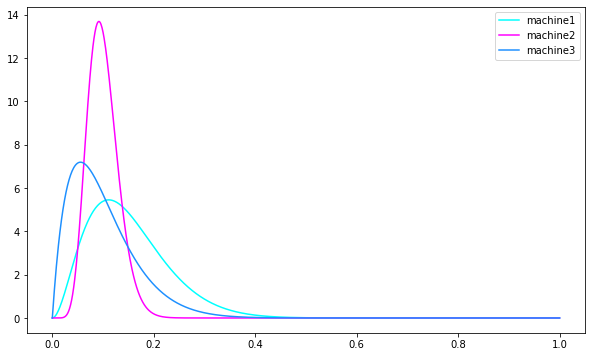

In [ ]:
from scipy.stats import beta

x = np.linspace(0, 1, 1000)

m1 = beta.pdf(x, 1+2, 9+8)
m2 = beta.pdf(x, 10, 90)
m3 = beta.pdf(x, 2, 8+10)

fig, ax = plt.subplots(1, 1)
ax.plot(x, m1, label='machine1', color='cyan', marker='')
ax.plot(x, m2, label='machine2',color='magenta', marker='')
ax.plot(x, m3, label='machine3',color='dodgerblue', marker='')

ax.legend()
plt.show()

In [ ]:
df = pd.DataFrame({
  'm1': m1,
  'm2': m2,
  'm3': m3,
})
step = 0.05
df['cluster'] = (df.index / step / len(x)).astype('int64')

df.groupby('cluster').sum() / len(x)


,m1,m2,m3
cluster,,,
0,0.07,0.03,0.24
1,0.23,0.50,0.34
2,0.26,0.41,0.22
3,0.20,0.06,0.12
4,0.13,0.00,0.05
5,0.07,0.00,0.02
6,0.03,0.00,0.01
7,0.01,0.00,0.00
8,0.00,0.00,0.00


In [ ]:
# 우리 실습할 숫자는 슬롯머신이나 배너 클릭 확률과는 약간 다르다. 
# 특정 기간동안 상품이 판매된 누적 판매량 (수요) 이다. => 베타분포가 아닌 다른 분포가 필요함  


# 수요는 프와송(poisson) 분포로 표현
# poisson(theta)

# 감마 (gamma) 분포 - 프와송분포의 사전확률모델 p(theta) = gamma(alpha, beta)
# beta는 시행횟수, beta가 커질수록 확률분포가 뾰족해짐, alpha 는 시행의 누적값을 의미

# likelihood = p(d|theta) 사전분포에 대한 정보에 추가되는 새로운 관측값의 정보, 사전분포에 곱해서 사후분포를 만듬 

# 사후분포 = p(theta) * likelihood = gamma(alpha + mean_d, beta + n)

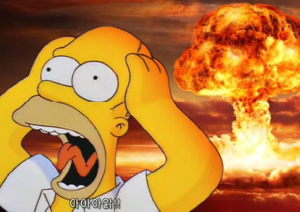

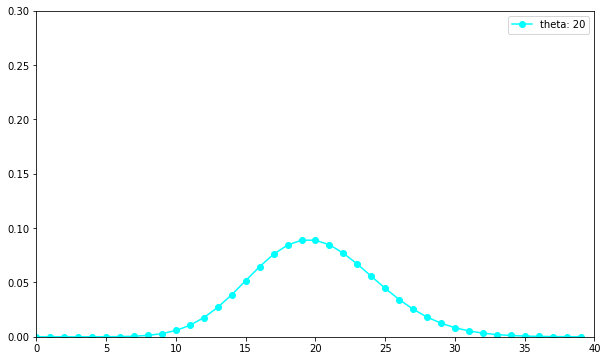

In [ ]:
# 프와송분포, 감마분포를 알아보자
# (프와송분포의 기대값이 충분히 크면 정규분포와 유사하다)
from scipy.stats import poisson

x = np.arange(0, 40)

theta = 20
poisson1 = poisson.pmf(x, theta)

fig, ax = plt.subplots(1, 1)
ax.plot(x, poisson1, label='theta: 20', color='cyan', marker='o')
plt.xlim(0, 40)
plt.ylim(0, 0.3)

ax.legend()
plt.show()


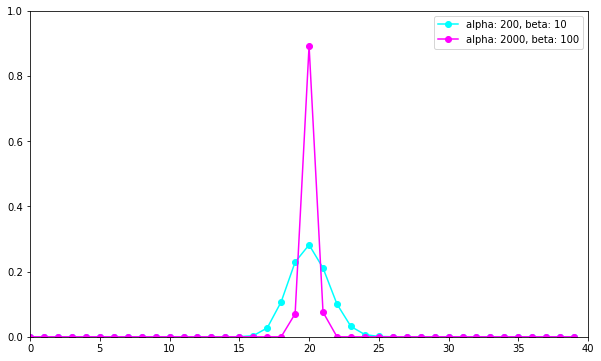

In [ ]:
# 감마분포
# 20을 10번 뽑았을때, 원래 확률 theta 의 분포
from scipy.stats import gamma

alpha = 20 * 10
beta = 10
scale = 1/beta

gamma1 = gamma.pdf(x, alpha, scale=scale)

alpha = 20 * 100
beta = 100
scale = 1/beta

gamma2 = gamma.pdf(x, alpha, scale=scale)

fig, ax = plt.subplots(1, 1)
ax.plot(x, gamma1, label='alpha: 200, beta: 10', color='cyan', marker='o')
ax.plot(x, gamma2, label='alpha: 2000, beta: 100', color='magenta', marker='o')
plt.xlim(0, 40)
plt.ylim(0, 1)

ax.legend()
plt.show()


In [ ]:
prices = [40, 50, 60, 70] 

# 감마분포의 확률 
initial_alpha = 100 # 사전분포   
initial_beta = 1 # 사전분포

T = 1000
t_interval = range(T) 

# price model 초기화
price_model = [{'alpha': initial_alpha, 'beta': initial_beta} for p in prices]

# 수요를 관측, 앞에서 사용한 함수와 동일
unknown_theta0 = 50
unknown_theta1 = -0.5

def sample_actual_demand(p): 
    demand = unknown_theta0 + unknown_theta1 * p
    demand = max(demand, 0) # 수요는 0보다 크다는 조건을 추가    
    return np.random.poisson(demand)

# 가격대별 수요를 실제가 아닌, 모델로부터 관측한다고 가정 (샘플링)
def sample_demands_from_model():
    demand_per_prices = np.array([])
    for model in price_model:
        scale = 1/model['beta']
        # demand = np.random.gamma(model['alpha'], scale)
        demand = gamma.rvs(model['alpha'], scale=scale)
        demand_per_prices = np.append(demand_per_prices, demand)

    return demand_per_prices

# 최적의 가격 도출
def optimal_price(prices, demands):
    revenue = np.multiply(prices, demands)
    price_index = np.argmax(revenue)
    return price_index, prices[price_index]

price_points = np.array([])
demand_points = np.array([])

for t in t_interval:
  # 1. 확률모델에서 가격별 수요값을 추정하여 최고의 매출을 올릴 가격을 선정
  demands = sample_demands_from_model()   
  opt_price_index, opt_p = optimal_price(prices, demands)
  
  # 2. 해당 가격을 설정하고 수요를 관측 
  realized_demand = sample_actual_demand(opt_p)
  demand_points = np.append(demand_points, realized_demand)
      
  # 3. 관측값을 모델의 해당 가격 섹션에 피드백
  model = price_model[opt_price_index]
  model['alpha'] = model['alpha'] + realized_demand
  model['beta'] = model['beta'] + 1

  price_points = np.append(price_points, opt_p)


df = pd.DataFrame({
  't':t_interval,
  'price': price_points,
  'demand': demand_points,
})
df['revenue'] = df['demand'] * df['price']


In [ ]:
# unknown_theta0 + unknown_theta1 * p
unknown_theta0 + unknown_theta1 * 50

25.0

In [ ]:
np.random.poisson(25)

28

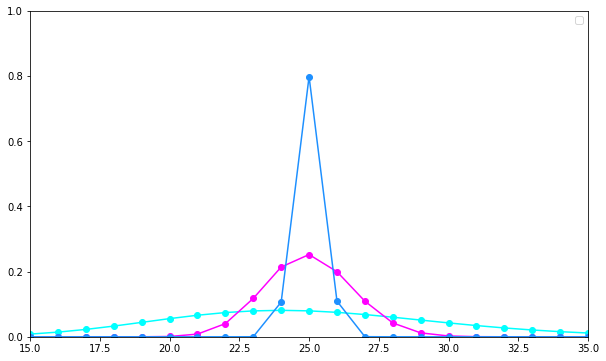

In [ ]:
# 감마분포
# 25를 10번 뽑았을때, 원래 확률 theta 의 분포
from scipy.stats import gamma

gamma1 = gamma.pdf(x, 25, scale=1/1)
gamma2 = gamma.pdf(x, 250, scale=1/10)
gamma3 = gamma.pdf(x, 2500, scale=1/100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, gamma1, color='cyan', marker='o')
ax.plot(x, gamma2, color='magenta', marker='o')
ax.plot(x, gamma3, color='dodgerblue', marker='o')

plt.xlim(15, 35)
plt.ylim(0, 1)

ax.legend()
plt.show()


In [ ]:
gamma.rvs(25, scale=1/1)
gamma.rvs(250, scale=1/10)
gamma.rvs(2500, scale=1/100)

25.006220291767608

In [ ]:
gamma.rvs(25, scale=1/1)

28.535763725663127

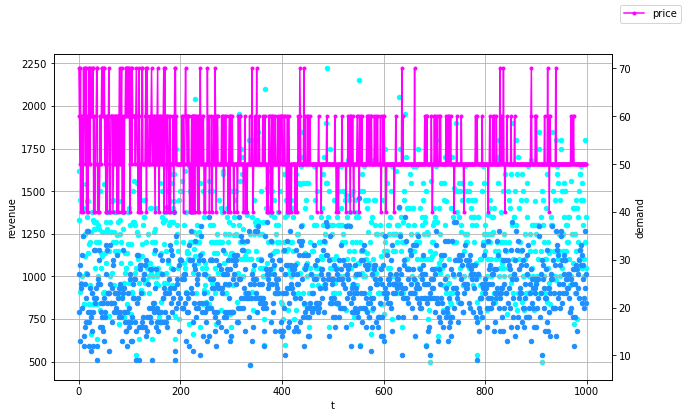

In [ ]:
ax = df.plot.scatter(x='t', y='revenue', legend=False, color='cyan', grid=True)
ax2 = ax.twinx()
df.plot(x='t', y='price', ax=ax2, legend=False, color='magenta')
df.plot.scatter(x='t', y='demand', ax=ax2, legend=False, color='dodgerblue')
ax.figure.legend()

# 점점 결과가 가장 좋은쪽으로 수렴

In [ ]:
df['cluster'] = (df['t']/100).astype('int64')
df.groupby('cluster').mean()

,t,price,demand,revenue
cluster,,,,
0,49.50,56.30,21.55,"1,165.00"
1,149.50,54.70,22.19,"1,173.00"
2,249.50,52.20,23.25,"1,184.70"
3,349.50,51.20,24.61,"1,241.70"
4,449.50,50.90,24.58,"1,238.10"
5,549.50,51.30,23.39,"1,188.00"
6,649.50,50.80,24.58,"1,241.90"
7,749.50,51.20,24.28,"1,233.80"
8,849.50,51.50,24.04,"1,226.20"


In [ ]:
df.groupby('price').mean()

,t,demand,revenue,cluster
price,,,,
40.00,288.51,29.00,"1,160.00",2.43
50.00,586.44,24.94,"1,247.11",5.36
60.00,363.34,19.67,"1,180.00",3.14
70.00,213.87,14.74,"1,031.51",1.70


## 정리 
아마 대부분의 분들에게 어려웠겠지만 가격 시스템에 대한 감각을 깨우는데 도움이 되었을거라 생각합니다. 

이번 실습에서의 최적 가격은 가격탄력성 실험 기반으로 찾는것이 아니라, 여러 가격을 실제로 도입해보고 결과적으로 좋은 가격을 최적의 가격으로 적용한다는 점이 이전 실습들과 다른 점이었습니다. 

톰슨샘플링같은것을 직접 구현하는 일은 흔치는 않을것이고, 사실 더 간단한 e-greddy, UCB 방법같은것도 있고 매우 효과적입니다. 하지만 마지막 실습이라 약간 도전적인 주제로 구현해보았습니다. 